# Movie Recommendation Data Preparation

This notebook includes preprocessing of a kaggle movie recommendation dataset.
The data is taken from [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/) and was downloaded from [Kaggle movie recommender system dataset ](https://www.kaggle.com/code/rounakbanik/movie-recommender-systems). The data includes 40954 valid movies.

# Importing Libraries
We will start by importing relevant libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
import ast

from matplotlib import pyplot as plt
import seaborn as sns
import sys


We first load the movie metadata from a csv file

In [3]:
df = pd.read_csv('movies_metadata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

# **Data Preparation**
The data includes a lot of duplications, with "spoken_languages" including both code and name of languages, etc.
The first step is clean and prepare the data.
* Syntax standartization
* Nan handling
* Remove duplications
* Remove irrelevant columns
* Flattening nested objects and removing duplicated entries

In [4]:
# Remove duplicates by only keeping last entry
df = df[~df["title"].duplicated(keep='last')]

# We will use overview, title and release date. We therefore remove entries without those
df = df[~df["title"].isna()]
df = df[~df["overview"].isna()]
df = df[~df["release_date"].isna()]

# We remove colums we won't use
for col in ['homepage','imdb_id','video', 'original_title','poster_path','original_language']:
  del(df[col])

In [5]:
# Normalizing data types and flattening dictionaries to lists
df['belongs_to_collection'] = df['belongs_to_collection'].fillna('{}')
df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: ast.literal_eval(x))
df['belongs_to_collection'] = df['belongs_to_collection'].map(lambda x: x['name'] if 'name' in x else 'None')

df['budget'] = df['budget'].apply(lambda x: ast.literal_eval(x))

df['spoken_languages'] = df['spoken_languages'].apply(lambda x: ast.literal_eval(x))
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: [d['iso_639_1'] for d in x])

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
df['genres'] = df['genres'].apply(lambda x: [d['name'] for d in x])

df['popularity'] = df['popularity'].apply(float)

df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: [d['iso_3166_1'] for d in x])

df['id'] = df['id'].apply(lambda x: ast.literal_eval(x))

df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['production_companies'] = df['production_companies'].apply(lambda x: [d['name'] for d in x])

df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0])

df['overview'] = df['overview'].fillna('')
df['tagline'] = df['tagline'].fillna('')
df['release_date'].fillna('1900')

df.rename(columns = {"runtime":"runtime_days"}, inplace = True)
df['status'] = df['status'].fillna('Released')

# Only keep released movies. assume missing statuses are "Released".
df = df[df['status']=='Released']
del(df['status'])

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40951 entries, 0 to 45465
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  40951 non-null  object 
 1   belongs_to_collection  40951 non-null  object 
 2   budget                 40951 non-null  int64  
 3   genres                 40951 non-null  object 
 4   id                     40951 non-null  int64  
 5   overview               40951 non-null  object 
 6   popularity             40951 non-null  float64
 7   production_companies   40951 non-null  object 
 8   production_countries   40951 non-null  object 
 9   release_date           40951 non-null  object 
 10  revenue                40951 non-null  float64
 11  runtime_days           40951 non-null  float64
 12  spoken_languages       40951 non-null  object 
 13  tagline                40951 non-null  object 
 14  title                  40951 non-null  object 
 15  vo

# **Movie Rating**
We will provide query boost for high rated movies. Fot the rating, we use the IMDB score, defined as
(WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$
, where:
* *v* = number of votes
* *m* = minimum required votes to be rated
* *R* = average movies rating
* *C* = mean vote across all movies

we will take m to be the 0.95 quantile


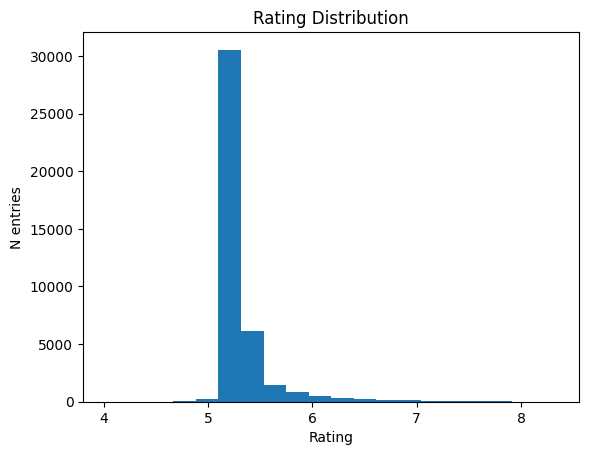

In [6]:
def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    return v * R / (v + m) + m * C / (m + v)

vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
C = df[df['vote_average'].notnull()]['vote_average'].astype('int').mean()
m = vote_counts.quantile(0.95)

df['rating'] = df.apply(lambda x: weighted_rating(x, m, C), axis=1)
df['rating'].plot.hist(bins=20)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('N entries')
del(df['vote_average'])
del(df['vote_count'])
df.reset_index(inplace=True)


In [7]:
from datetime import datetime

df['unix_time'] = df['release_date'].apply(lambda x: int(datetime.strptime(x, "%Y-%m-%d").timestamp()))
del(df['release_date'])
df.rename({"unix_time":"release_date_unix"}, inplace=True)

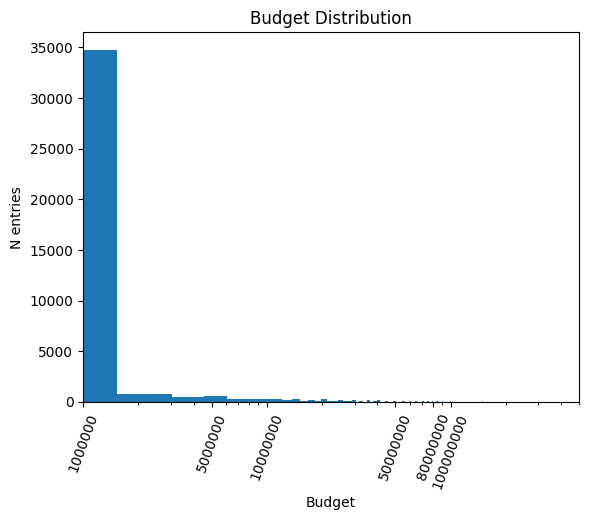

In [8]:
df['budget'].plot.hist(bins=250)
plt.title('Budget Distribution')
plt.xlabel('Budget')
plt.ylabel('N entries')
plt.xscale('log')
x_ticks = [10**6, 5*10**6,10**7, 5 * 10**7, 8 *10**7, 10**8]
plt.xticks(x_ticks, [str(x) for x in x_ticks], rotation = 70)

plt.show()



# **Data Overview**
The cleaned data includes 40951 entries

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40951 entries, 0 to 40950
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level_0                40951 non-null  int64  
 1   index                  40951 non-null  int64  
 2   adult                  40951 non-null  object 
 3   belongs_to_collection  40951 non-null  object 
 4   budget                 40951 non-null  int64  
 5   genres                 40951 non-null  object 
 6   id                     40951 non-null  int64  
 7   popularity             40951 non-null  float64
 8   production_companies   40951 non-null  object 
 9   production_countries   40951 non-null  object 
 10  revenue                40951 non-null  float64
 11  runtime_days           40951 non-null  float64
 12  spoken_languages       40951 non-null  object 
 13  title                  40951 non-null  object 
 14  year                   40951 non-null  object 
 15  ra

In [14]:
df.to_csv('Movie_Recommendation_Processed.csv', index = False)

Done!









